# Smoothing

<!-- <img src="media/cover.png" style="width: 40%; display: block; margin: auto;"> -->

## Introduction

In the previous lectures, we learned that:
- A time series consists of measurements characterized by temporal dependencies.
- A time series can be decomposed into trend, seasonality, and residuals.
- Many time series models require the data to be **stationary** in order to make forecasts.  

In this lecture, we will build upon that knowledge and explore another important concept called **smoothing**. In particular, we will cover:
1. An introduction to smoothing and why it is necessary.
2. Common smoothing techniques.
3. How to smooth time series data with Python and generate forecasts.

In [91]:
# Imports
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
from io import BytesIO
from statsmodels.tsa.seasonal import seasonal_decompose
np.random.seed(0) # reproducibility

def ts_plot(x,y,title,xlabel="Time",ylabel="Value"):
    plt.figure(figsize=(10,5))
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3);

## Smoothing

- A data collection process is often affected by noise.
- If too strong, the noise can conceal useful patterns in the data.
- Smoothing is a well-known and often-used technique to recover those patterns by **filtering out noise**.
- It can also be used to **make forecasts** by projecting the recovered patterns into the future.

- We will explore two important techniques to do smoothing:
    1. **Simple smoothing**
    2. **Exponential smoothing**

- We start by generating some stationary data.
- We discussed the importance of visually inspecting the time series with time plot.

In [92]:
# Generate stationary data
time = np.arange(100)
stationary = np.random.normal(loc=0, scale=1.0, size=len(time))

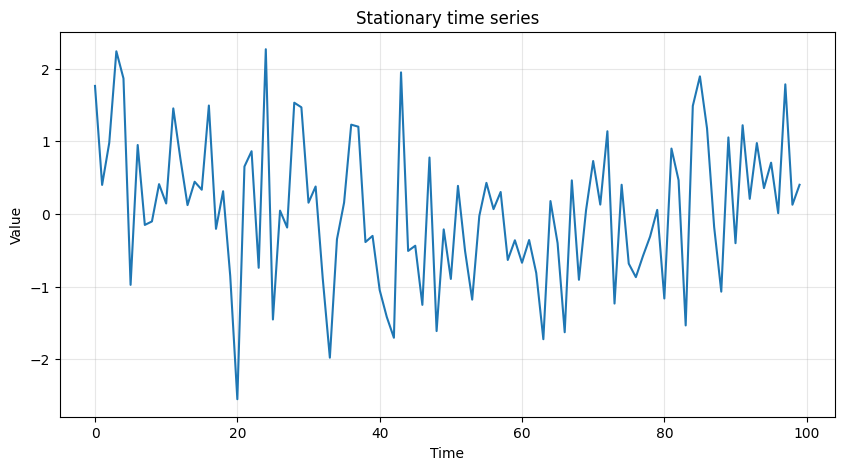

In [93]:
ts_plot(time, stationary,'Stationary time series')

## Mean squared error (MSE)

- In general we want to measure how far our estimated time series is from reality.
- A common way of doing it is by calculating the *Mean Squared Error* (MSE)

$$MSE = \frac{1}{T}\sum_{t=1}^{T} (X(t) - \hat{X}(t))^2$$

- where $X(t)$ and $\hat{X}(t)$ are the true and estimated values at time $t$, respectively.

- Mean absolute error (MAE), root MSE (**RMSE**), etc.
- **RMSE** is more intutitive as it is measured in the same units as the time series $RMSE=\sqrt{MSE}$.

**Example**

- Let's consider the following example.
- Say we have a time series of observed values $X = [0, 1, 3, 2]$.
- The predictions given by our model are $\hat{X} =  [1, 1, 2, 4]$.
- We calculate the RMSE as:

$$\left(\frac{(0-1)^{2} + (1-1)^{2} + (3-2)^{2} + (2-4)^{2}}{4}\right)^{0.5} = 1.22$$

- Say we had another model that give us the estimate $\hat{X} =  [0, 0, 1, 0]$.
- The RMSE in this case is:

$$\left(\frac{0^{2} + 1^{2} + 2^{2} + 2^{2}}{4}\right)^{0.5} = 1.5$$

- The MSE allows to compare different estimates to see which is best.
- In this case, the first model gives us a better estimate than the second one.
- This idea of measuring how a model performs is important in machine learning and we will use it often in this course.
- Let's create a function to calculate MSE that we will use as we go forward.

In [94]:
def mse(observations, estimates):
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = np.mean(sq_diff)
    return mse

Let's test the ``mse`` function.

In [95]:
mse(np.array([0, 1, 3, 2]), np.array([1, 1, 2, 4]))**0.5

1.224744871391589

In [96]:
mse(np.array([0, 1, 3, 2]), np.array([0, 0, 1, 0]))**0.5

1.5

## Simple smoothing techniques

- There are many techniques for smoothing data.
- The most simple ones are:
    1. Simple average
    2. Moving average
    3. Weighted moving average

### Simple average (SA)

- Simple average is the most basic technique.
- Consider the stationary data above.
- The most conservative way to represent it is through its **mean**.
- The mean can be used to predict the future values of the time series.
- This type of representation is called *simple average*.

In [97]:
# find mean of series
stationary_SA = np.mean(stationary)

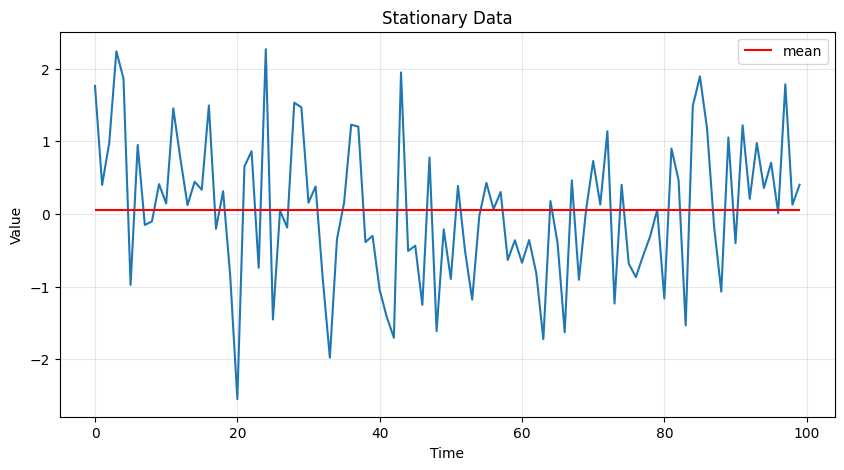

In [98]:
ts_plot(time, stationary, title="Stationary Data")
plt.hlines(stationary_SA, xmin=time[0], xmax=time[-1], colors='red', label="mean")
plt.legend();

- Next, we add a *trend* to our stationary time series.

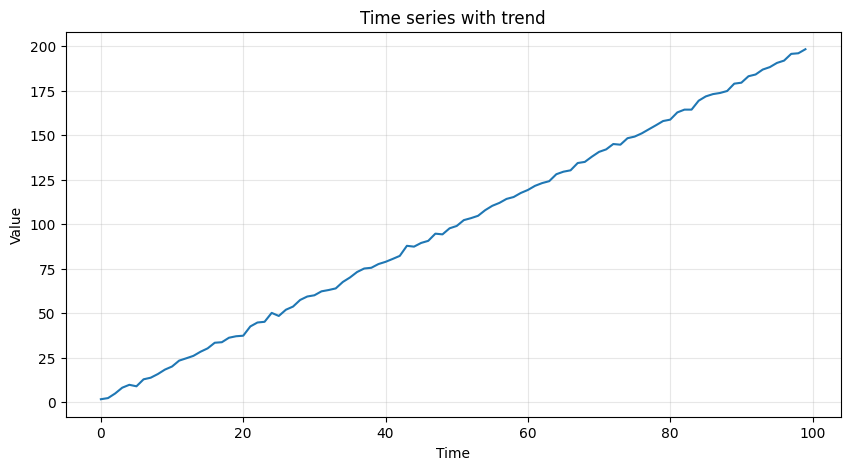

In [99]:
trend = (time * 2.0) + stationary
ts_plot(time, trend, "Time series with trend");

- Suppose we use again the simple average to represent the time series.

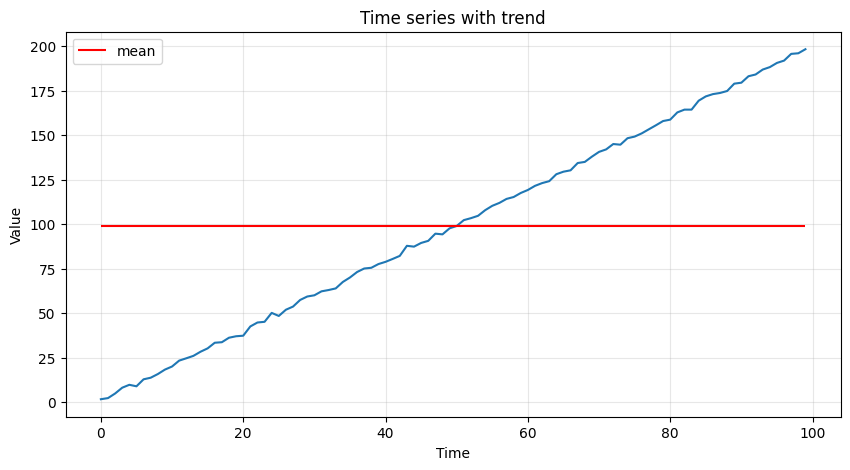

In [100]:
# find mean of series
trend_SA = np.mean(trend)

ts_plot(time, trend, "Time series with trend")
plt.hlines(trend_SA, xmin=time[0], xmax=time[-1], colors='red', label="mean")
plt.legend();

- Clearly, the simple average can remove noise, but it also removes the trend!
- We must find other ways to capture the underlying pattern in the data.
- We start with something called a *moving average*.

### Moving Average (MA)

- Moving average has a greater sensitivity to local changes in the data than the simple average.
- The easiest way to understand moving average is by example.
- Say we have the following values:

<img src="https://github.com/nsydn/ise043_tsaf/blob/main/media/values.png?raw=1" style="width: 30%; display: block; margin: auto;">

- The first step is to select a window size.
- We'll arbitrarily choose a size of 3.
- Then, we start computing the average for the first three values and store the result.
- We then slide the window by one and calculate the average of the next three values.
- We repeat this process until we reach the final observed value.

<img src="https://github.com/nsydn/ise043_tsaf/blob/main/media/EqWMA.gif?raw=1" style="width: 40%; display: block; margin: auto;">

- Now, let's define a function to perform smoothing with the MA.
- Then, we compare the MSE obtained from applying simple and MA on the data with trend.

In [101]:
def moving_average(obs, w=3):
    obs_MA = []
    for i in range(len(obs)-w+1):
        obs_MA.append(np.average(obs[i:i+w]))
    return np.array(obs_MA)

moving_average(trend)

array([  3.04764918,   5.20659613,   7.69572972,   9.04372444,
        10.61345618,  11.94048444,  14.23183745,  16.05200748,
        18.15047441,  20.66963853,  22.7864516 ,  24.77899542,
        26.44219199,  28.29973753,  30.75720554,  32.54086505,
        34.53399617,  35.75127123,  36.96866072,  39.08217768,
        41.65502166,  44.25862992,  46.79734193,  48.02440798,
        50.28704916,  51.46806966,  54.46378463,  56.93831804,
        59.0523618 ,  60.66748957,  61.88177473,  63.1698601 ,
        64.92783521,  67.27588012,  70.3462425 ,  72.8630065 ,
        74.68178124,  76.17091676,  77.42060582,  79.07637545,
        80.6083863 ,  83.60816242,  85.91161767,  88.33434964,
        89.26649272,  91.69554023,  93.30359905,  95.65028408,
        97.09263177,  99.75956522, 101.66021027, 103.56515506,
       105.42679348, 107.73983915, 110.15555562, 112.26577366,
       113.91155568, 115.76846955, 117.4434921 , 119.53508174,
       121.3849467 , 123.03367265, 125.21266575, 127.34

In [102]:
len(moving_average(trend))

98

In [103]:
# Alternatively
import pandas as pd

def moving_average2(obs, w=3):
    df = pd.DataFrame(obs)
    obs_MA = df.rolling(w).mean()
    return obs_MA
moving_average2(trend)

,0
0,NaN
1,NaN
2,3.047649
3,5.206596
4,7.695730
...,...
95,188.679860
96,190.357813
97,192.834315
98,194.641094


Let's compare the RMSE values from SA and MA on `trend` data:

In [104]:
w = 3
lost = int((w-1)/2)
trend_MA = moving_average(trend, w)
print("RMSE (SA): %.2f" % mse(trend, trend_SA)**0.5)
print("RMSE (MA): %.2f" % mse(trend[lost:-lost], trend_MA)**0.5)
# notice that as we increase w, MSE values converge

RMSE (SA): 57.65
RMSE (MA): 0.80


- Clearly, the MA manages to pick up much better the trend data.
- We can also plot the result against the actual time series.

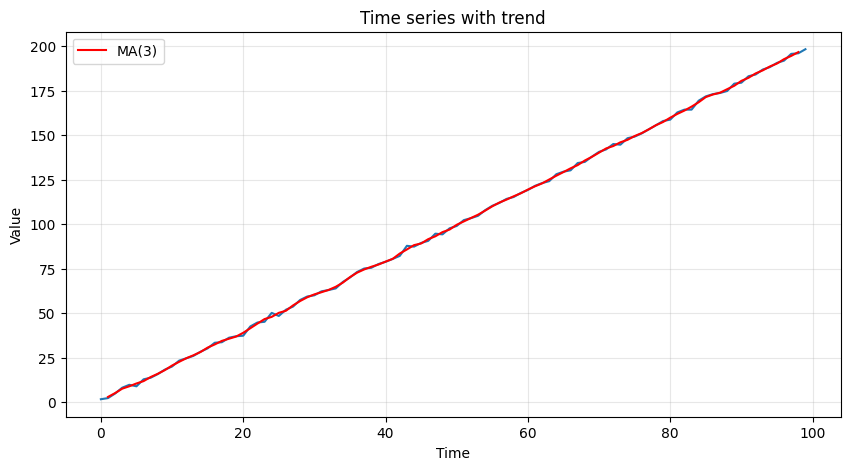

In [105]:
ts_plot(time, trend, "Time series with trend")
plt.plot(time[lost:-lost], trend_MA, 'r', label="MA(%.0f)" % w)
plt.legend();

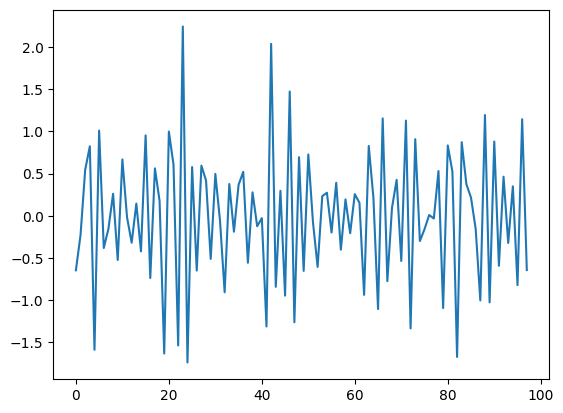

In [106]:
plt.plot(trend[lost:-lost]-trend_MA)

- Note that the output of the MA will always be shorter than the original data.
- The reason is that the first and last $\frac{(w-1)}{2}$ elements of the time series will be `lost`.
- Given a window of size $w$, the MA will lose in total $w-1$ data points.

⚡ ***Exercise:***  Apply MA on `stationary` and compare MSE values for SA and MA.

- Now, we try the MA on a periodic time series that exhibit some seasonality (e.g., energy prices).

RMSE (MA): 2.17


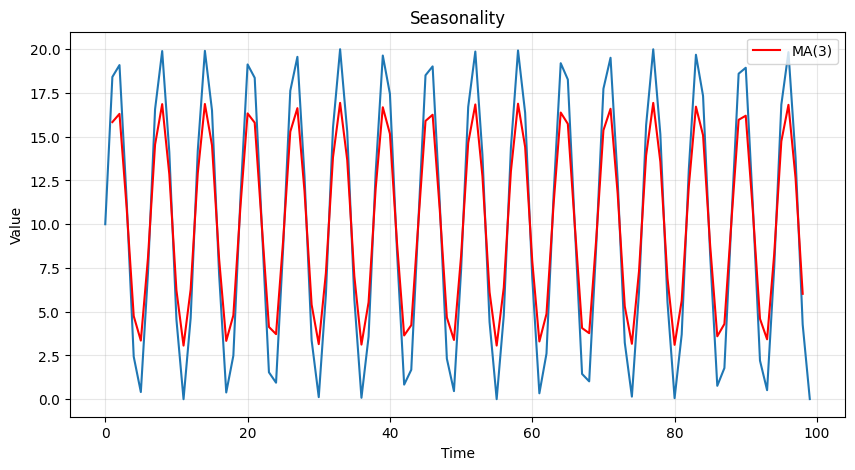

In [107]:
w = 3
seasonality = 10 + np.sin(time) * 10
seasonality_MA = moving_average(seasonality, w)
lost = int((w-1)/2)
print('RMSE (MA): %.2f' % mse(seasonality_MA,seasonality[lost:-lost])**0.5)

ts_plot(time, seasonality, "Seasonality")
plt.plot(time[lost:-lost], seasonality_MA, 'r', label="MA(%.0f)" % w)
plt.legend();

- It's not perfect but clearly picks up the periodic pattern.
- There is a trade-off between smoothing and recovering pattern, that depends on the choice of `w`.

- Lastly, let's see how MA handles trend, seasonality, and a bit of noise.

RMSE (MA): 6.25


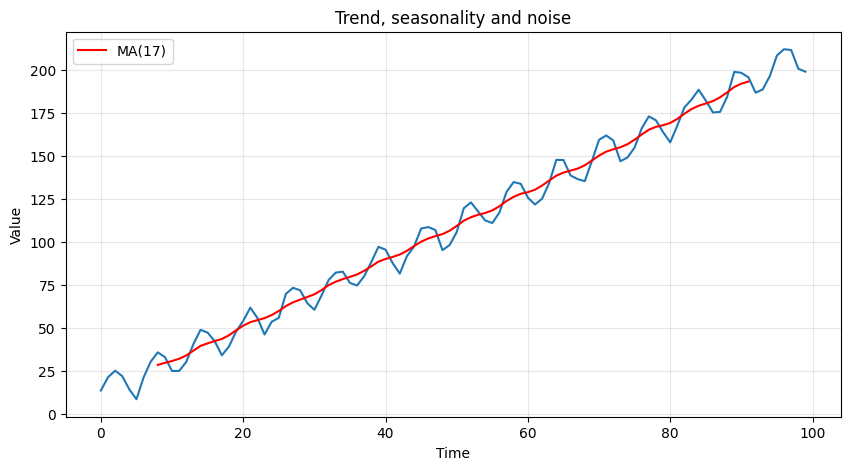

In [108]:
w = 17
trend_seas = trend + seasonality + stationary
trend_seas_MA = moving_average(trend_seas, w)
lost = int((w-1)/2)
print('RMSE (MA): %.2f' % mse(trend_seas_MA,trend_seas[lost:-lost])**0.5)

ts_plot(time, trend_seas, "Trend, seasonality and noise")
plt.plot(time[lost:-lost], trend_seas_MA, 'r', label="MA(%.0f)" % w)
plt.legend();

- This method is picking up key patterns in these datasets.
- However, it has several **limitations**.
1. MA assigns equal importance to all values in the window, regardless of their chronological order.
    - For this reason it fails in capturing the often more relevant recent trends.
2. MA requires the selection of a specific window size, which can be arbitrary and may not suit all types of data.
    - a small window may lead to noise
    - a too large window could oversmooth the data, missing important short-term fluctuations.

<!-- 3. MA does not adjust for changes in trend or seasonality.
    - This can lead to inaccurate predictions, especially when these components are nonlinear and time-dependent. -->

### Weighted moving average (WMA)

- WMA weights *recent* observations more than more *distant* ones.
- This makes intuitive sense.
    - Think of the stock market: it has been observed that today's price can be a better predictor of tomorrow's price.
- By applying unequal weights to past observations, we can control how much each affects the future forecast.

<img src="https://github.com/nsydn/ise043_tsaf/blob/main/media/ExpWMA.gif?raw=1" style="width: 40%; display: block; margin: auto;">

In [109]:
def weighted_moving_average(obs, weights):
    obs_WMA = []
    w = len(weights)
    for i in range(len(obs)-w+1):
        obs_WMA.append(np.average(obs[i:i+w], weights=weights))
    return np.array(obs_WMA)

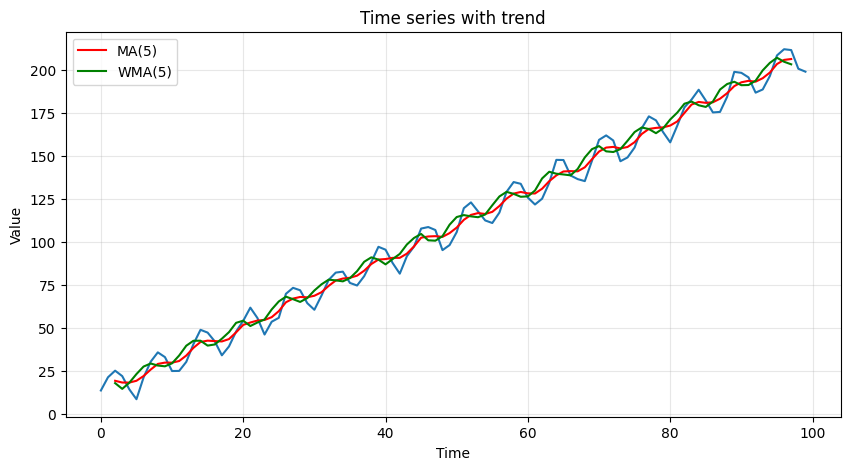

In [110]:
w = 5
loss = int((w-1)/2)
weights = [0.1,0.1,0.1,0.2,0.4] #[0.543,0.294,0.16]
trend_MA = moving_average(trend_seas,w)
trend_WMA = weighted_moving_average(trend_seas,weights)
ts_plot(time, trend_seas, "Time series with trend")
plt.plot(time[loss:-loss], trend_MA, 'r', label="MA(%.0f)" % w)
plt.plot(time[loss:-loss], trend_WMA, 'g', label="WMA(%.0f)" % w)
plt.legend();

**📝Note**

- There are numerous methods to find the optimal weighting scheme based on the data and the task at hand.
- A full discussion is beyond the scope of the lecture.

### Forecasting with MA

- Instead of pulling out the inherent pattern within a series, the smoothing functions can be used to create *forecasts*.
- The forecast for the next time step can be computed as follows:

$$\hat{X}(t+1) = \frac{X(t) + X(t-1) + \dots + X(t-w+1)}{w}$$

where $w$ is the window size of the MA.

- While the formula is easy to understand, one of its properties may not be obvious: 
> - **What's the lag associated with the MA technique?** In other words, how many time steps are required for the impact of any value $X(t)$ to be visible in the MA series?

- The answer is: $\frac{(w+1)}{2}$.
- For example, say you're averaging $X(1),X(2),X(3),X(4),X(5)$ to predict $X(6)$. 
- Assume $X(3)$ is an extremely high or low value and $X(6)$ abnormally low.
- The predicted value $\hat{X}(6)$ will more likely represent $X(3)$, as $X(3)$ sits at the center of estimation window **(3 time steps delay!)**.
- You will probably see a value that closely represents $X(6)$ when you compute $\hat{X}(9)$ using $X(4),X(5),X(6),X(7),X(8)$ **(again, 3 time steps delay!)**.
- The easy way to get this lag value is $\frac{5+1}{2} = 3$.
- Clearly, the lag increases as you increase the window size.

- One might reduce the window size to obtain a more responsive model.
- However, a window size that's too small will chase noise in the data as opposed to extracting the pattern.
- Again, there is a trade-off between *responsiveness* and *robustness to noise*.
- The best answer lies somewhere in-between and requires careful tuning of `w`.

- Let's consider a practical example to show this tradeoff.
- We will generate some data (trend+seasonal+noise) and apply MA with different window sizes.

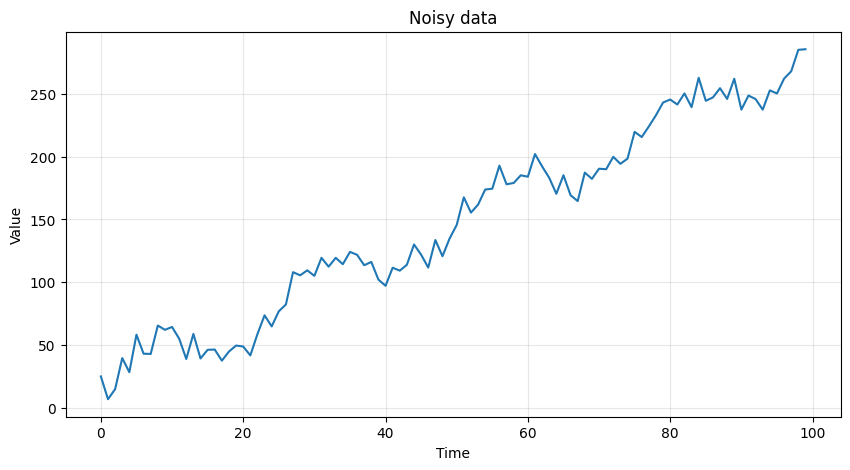

In [111]:
ts_noise = np.random.normal(loc=0, scale=8.0, size=len(time))
ts_trend = time * 2.75
ts_seasonal = 10 + np.sin(time * 0.25) * 20
noisy_ts = ts_trend + ts_seasonal + ts_noise

ts_plot(time, noisy_ts, title="Noisy data");

In [112]:
# Compute MA with different window sizes
noisy_ts_MA3 = moving_average(noisy_ts[:-1], w=3)
noisy_ts_WMA3 = weighted_moving_average(noisy_ts[:-1], [0.2,0.2,0.6])
noisy_ts_MA9 = moving_average(noisy_ts[:-1], w=9)
noisy_ts_MA19 = moving_average(noisy_ts[:-1], w=19)

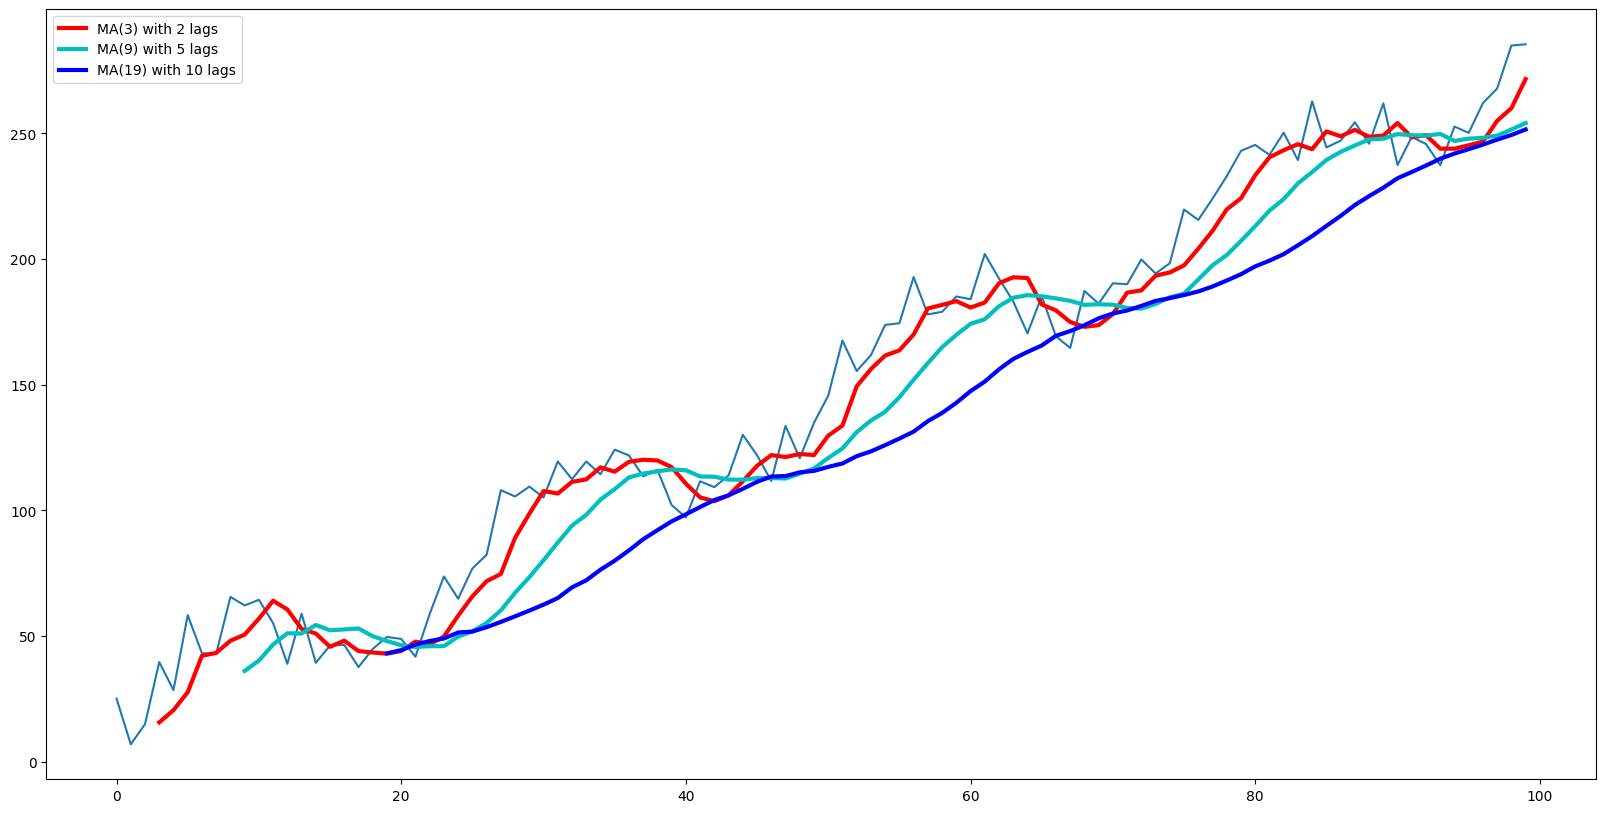

In [113]:
plt.figure(figsize=(20,10))
plt.plot(time, noisy_ts)
plt.plot(time[3:], noisy_ts_MA3, 'r', lw=3, label='MA(3) with 2 lags')
# plt.plot(time[3:], noisy_ts_WMA3, 'k', lw=3, label='WMA(3) with 2 lags')
plt.plot(time[9:], noisy_ts_MA9, 'c', lw=3, label='MA(9) with 5 lags')
plt.plot(time[19:], noisy_ts_MA19, 'b', lw=3, label='MA(19) with 10 lags')
plt.legend();

- Clearly, the larger the window size the smoother the data.
- This allows to get rid of the noise but, eventually, also the underlying signal is smoothed out.

### Forecasting with WMA

- Next, we use the WMA to generate forecasts.
- The previous forecasting formula is modified to weight differently the past observations in the window:

$$\hat{X}(t+1) = \frac{w_1 \cdot X(t) + w_2 \cdot X(t-1) + \dots + w_P \cdot X(t-P+1)}{P}$$

- WMA solves some issues of MA.
    - It is more sensitive to local changes.
    - Is more flexible, as it can adjust the importance of different time steps.
    - It does not require a fixed window size as it applies an exponentially decreasing weight to all past observations.
- However it still struggle in keeping pace with nonlinear and fast-changing trends... There's a significant lag.

---

## Exponential Smoothing

There are three key exponential smoothing techniques:

|Type | Capture trend | Capture seasonality|
|:----:|:---------------:|:--------------------:|
|Single Exponential Smoothing | ❌ | ❌ |
|Double Exponential Smoothing | ✅ | ❌ |
|Triple Exponential Smoothing | ✅ | ✅ |

### Single exponential smoothing (ES1)

- 💡 Useful if your data lacks trend and seasonality and you want to approximately extract patterns.
- It is analogous to the WMA we saw previously.
- The basic formulation is:

$$S(t) = \alpha X(t) + (1-\alpha)S(t-1)$$

- where:
    - $S(t)$ is the smoothed value at time *t*,
    - $\alpha$ is a smoothing constant,
    - $X(t)$ is the value of the series at time *t*.

Expanding the formula we get:

$$
\begin{aligned}
S(0) &= \alpha X(0) \\ S(1) &= \alpha X(1) + (1 - \alpha)S(0) = \alpha X(1) + \alpha(1 - \alpha)X(0) \\
S(2) & = \alpha X(2) + (1 - \alpha)S(1) = \alpha X(2) + (1 - \alpha)[\alpha X(1) + \alpha(1 - \alpha)X(0)]\\
& = \alpha X(2) + \alpha(1 - \alpha)X(1) + \alpha(1 - \alpha)^2 X(0)
\end{aligned}
$$

The formula for any time step $t$ is:

$$ S(t) = \alpha\sum_{i=0}^{t} (1 - \alpha)^{t-i}X(i) $$


<!-- #### Initialization

- There are many initialization strategies.
- A simple one is to set $S(0) = X(0)$.
- Another strategy is to find the mean of the first couple of observations, e.g., $S(0) = \frac{X(0) + X(1) + X(2)}{3}$.
- Once you've initialized it, you can use the update rule above to calculate all values.
- In practice, we don't perform this process by hand, but we use the functions in ``statsmodels``. -->

#### Setting $\alpha$
- Choosing the optimal value for $\alpha$ is also done by ``statsmodels``.
- A solver uses a metric like MSE to find the optimal $\alpha$.
- Even if we do not choose the value manually, is good to have a basic idea of what's happening under the hood.

## Exponential smoothing in Python

- Let's now see how to perform smoothing in Python.
- As we've done in the past, we'll leverage ``statsmodels`` to do the heavy lifting for us.

- We'll use the same time series with trend and seasionality to compare simple average, single, double, and triple exponential smoothing.
- We will holdout the last 5 samples from the dataset (i.e., they become the *test set*).
- We will compare the predictions made by the models with these values.

In [114]:
# Train/test split
train = trend_seas[:-5]
test = trend_seas[-5:]

### Simple Average (SA)

- This is a very crude model to say the least.
- It can at least be used as a baseline.
- Any model we try moving forward should do much better than this one.

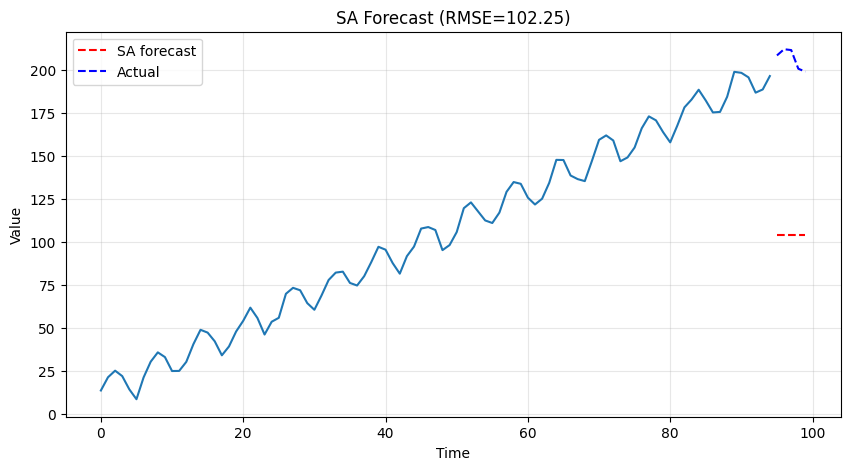

In [115]:
# find mean of series
trend_seas_SA = np.mean(train)
mse_SA = mse(test,trend_seas_SA)

ts_plot(time[:-5], train, "SA Forecast (RMSE=%.2f)" % mse_SA**0.5)
plt.hlines(trend_seas_SA, xmin=time[-5], xmax=time[-1], colors='red', linestyles='--', label="SA forecast")
plt.plot(time[-5:], test, 'b--', label="Actual")
plt.legend();

### Single Exponential Smoothing (ES1)

In [116]:
from statsmodels.tsa.api import SimpleExpSmoothing

es1 = SimpleExpSmoothing(train).fit() #smoothing_level=0.5
preds_es1 = es1.forecast(len(test))
mse_es1 = mse(test, preds_es1)
print("Predictions: ", preds_es1)
print("Test: ", test)
print("RMSE: ", mse_es1**0.5)

Predictions:  [196.26021282 196.26021282 196.26021282 196.26021282 196.26021282]
Test:  [208.24576348 211.8568775  211.36781838 200.52000547 198.81191039]
RMSE:  11.31199463322772


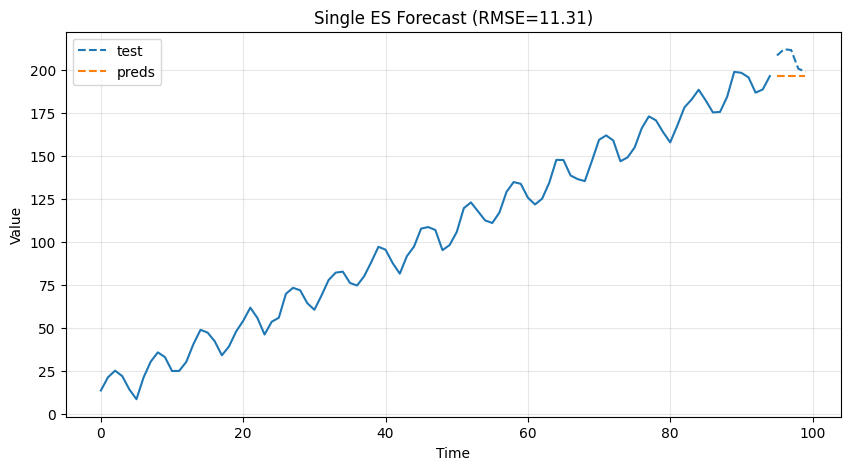

In [117]:
ts_plot(time[:-5], train, title="Single ES Forecast (RMSE=%.2f)" % mse(test,preds_es1)**0.5)
# plt.plot(time[:-5], es1.fittedvalues, color='tab:orange', label="fitted")
plt.plot(time[-5:], test, color='tab:blue', linestyle="--", label="test")
plt.plot(time[-5:], preds_es1, color='tab:orange', linestyle="--", label="preds")
plt.legend();

- This is certainly better than the simple average method but it's still pretty crude.
- Notice how the forecast is just a horizontal line.
- Single Exponential Smoothing cannot pick up neither trend nor seasonality.

### Double Exponential Smoothing (ES2)

Recursive application of an exponential smoothing **twice**.

In [118]:
from statsmodels.tsa.api import Holt

es2 = Holt(train).fit(optimized=True)
preds_es2 = es2.forecast(len(test))
mse_es2 = mse(test, preds_es2)
print("Predictions: ", preds_es2)
print("Test: ", test)
print("RMSE: ", mse_es2**0.5)

Predictions:  [198.18310489 200.10599693 202.02888897 203.95178101 205.87467305]
Test:  [208.24576348 211.8568775  211.36781838 200.52000547 198.81191039]
RMSE:  8.81153328908663


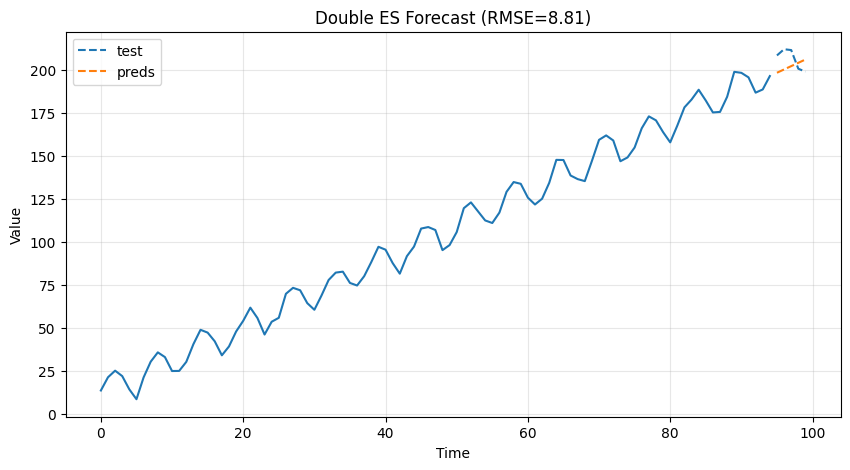

In [119]:
ts_plot(time[:-5], train, title="Double ES Forecast (RMSE=%.2f)" % mse(test,preds_es2)**0.5)
# plt.plot(time[:-5], es2.fittedvalues, color='tab:orange', label="fitted")
plt.plot(time[-5:], test, color='tab:blue', linestyle="--", label="test")
plt.plot(time[-5:], preds_es2, color='tab:orange', linestyle="--", label="preds")
plt.legend();

- Double Exponential Smoothing can pickup on trend, which is exactly what we see here.
- This is a significant leap but no quite yet the prediction we would like to get.

### Triple Exponential Smoothing (ES3)

Recursive application of an exponential smoothing **t**.

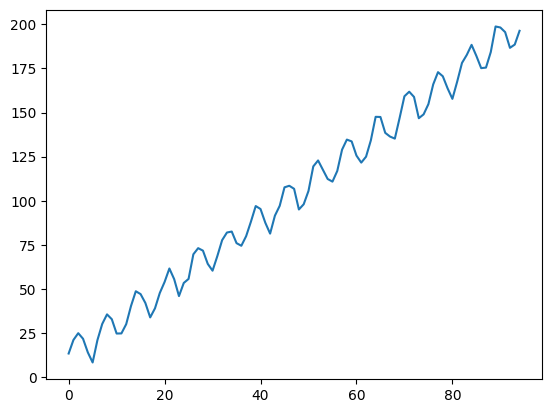

In [120]:
plt.plot(train)

In [121]:
from statsmodels.tsa.api import ExponentialSmoothing

es3 = ExponentialSmoothing(train, trend="additive", seasonal="additive", seasonal_periods=6).fit(optimized=True)
preds_es3 = es3.forecast(len(test))
mse_es3 = mse(test, preds_es3)
print("Predictions: ", preds_es3)
print("MSE: ", mse_es3**0.5)

Predictions:  [210.47813027 210.09908868 207.34989098 198.53305484 200.34088111]
MSE:  2.4699290599998776


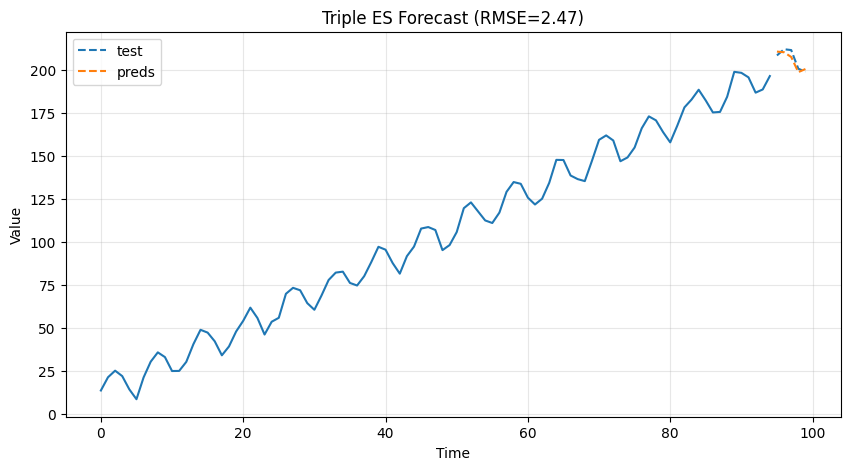

In [122]:
ts_plot(time[:-5], train, title="Triple ES Forecast (RMSE=%.2f)" % mse(test,preds_es3)**0.5)
# plt.plot(time[:-5], es3.fittedvalues, color='tab:orange', label="fitted")
plt.plot(time[-5:], test, color='tab:blue', linestyle="--", label="test")
plt.plot(time[-5:], preds_es3, color='tab:orange', linestyle="--", label="preds")
plt.legend();

- Triple Exponential Smoothing pickups trend and seasonality.
- Clearly, this is the most suitable approach for this data.
- We can summarize the results in the following table:

In [123]:
data_dict = {'RMSE':[mse_SA**0.5, mse_es1**0.5, mse_es2**0.5, mse_es3**0.5]}
df = pd.DataFrame(data_dict, index=['SA', 'ES1', 'ES2', 'ES3'])
print(df)

           RMSE
SA   102.254891
ES1   11.311995
ES2    8.811533
ES3    2.469929


---

## Summary

In this lecture we learned

1. What is smoothing and why it is necessary.
2. Some common smoothing techniques.
3. A basic understanding of how to smooth time series data with Python and generate forecasts.
---

## A small note on "Trend"
- **Trend** should **not** always be understood as a linear component in the time series
- "Trend", in its general meaning, any deterministic component that can be found in the time series
- By **deterministic**, we mean the values that can be explained by previous values in the time series
- **Examples of fitting trend:** fitting a linear or non-linear regression, applying a smoothing filter, etc.

## Exercises

Load the following two time series.

In [124]:
# Load the first time series
response = requests.get("https://zenodo.org/records/10897398/files/smoothing_ts1.npy?download=1")
response.raise_for_status()
smoothing_ts1 = np.load(BytesIO(response.content))
print(len(smoothing_ts1))

# Load the second time series
response = requests.get("https://zenodo.org/records/10897398/files/smoothing_ts4_4.npy?download=1")
response.raise_for_status()
smoothing_ts2 = np.load(BytesIO(response.content))
print(len(smoothing_ts2))

144
1000


Using on what you learned in this and in the previous lectures, do the following.

1. Create two time variables called `time1` and `time2` that range from 0 to the length of dataset.
2. Split each dataset into train and test sets (as the test, use the last 5 observations).
3. Identify trend and seasonality, if present.
4. Identify if trend and/or seasonality are additive or multiplicative, if present.
5. Create smoothed model on the train set and use to forecast on the test set.
6. Calculate MSE on test data.
7. Plot training data, test data, and your model's forecast for each dataset.

<!-- plt.plot(train1-es3.fittedvalues)
from statsmodels.tsa.stattools import adfuller
testval_after, pvalue_after, _, _, _, _ = adfuller(train1-es3.fittedvalues)
testval_after, pvalue_after -->